Creator: Csenge Rekeczky

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

from torch import Tensor
from tqdm import tqdm
from datetime import datetime


# sbi
from sbi import utils as utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi import analysis as analysis
from sbi.utils import get_density_thresholder
from sbi.diagnostics import run_sbc
from sbi.analysis.plot import sbc_rank_plot
from sbi.utils import process_simulator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

from CA3model_passive import CA3model_passive_solver

In [31]:
# SETTINGS

# DATA
# real, experimental data
#x_obs = [-5.6, -1.7, -10.5, -5.4, -1.75, -8.36, -5.3, -12.1]

# CALIBRATION DATA
# for panka:
#x_obs = x_obs = [-8.799761107919297, -7.780730625812472, -8.965067337261244, -7.506729998553134, -6.587400141841358, -7.5225870365844125, -8.031715153049307, -8.530727611781275]
#for csenge:
x_obs = [-2.8119144537299374, -3.248968963422385, -9.741790146427942, -9.411439258241455, -3.704493015061532, -3.615361259508341, -9.81779902904695, -10.275134644422286]

# PRIOR
# prior for 5 param
prior_min = [0.05, -80, 0.4, 0.3, 0.4]
prior_max = [1, -40, 4, 0.99, 4]

#OTHER
num_simulations = 10_000 # for model
sample_type = 'direct' #mcmc - monte carlo markv chain; or direct
posterior_sample_size = 1_000_000
save_dir = "results"

# INCLUDE ARTICLE VALUES ON GRAPH?
article_params = np.array([0.1, -60, 2.1, 0.5, 3]) #csenge calibration params
#article_params = np.array([0.12, -62, 0.45, 0.35, 0.5]) #panka calibration params
labels_params = ["gL", "VL", "gc", "pp", "Cm"]

/var/folders/gv/3fwhckrs62931wg2k41znhdc0000gn/T/ipykernel_22441/2962214090.py:3: DeprecationWarning: you passed deprecated arguments **kwargs: ['labels_params'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = analysis.pairplot(


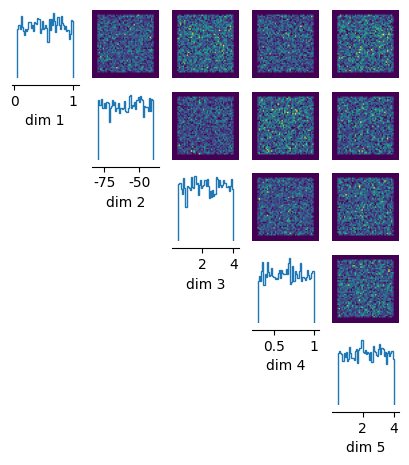

In [4]:
# PRIOR
prior = utils.torchutils.BoxUniform( #uniform distributions for 5 parameters
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

prior_samples = prior.sample((5000,))

fig, axes = analysis.pairplot( #visualizing the prior distributions
    prior_samples,
    labels_params=labels_params,
    figsize=(5, 5),
)
plt.show()

In [ ]:
# SIMULATOR
# prior, num_parameters, prior_returns_numpy = process_prior(prior)
# simulation_wrapper = process_simulator(CA3model_passive_solver, prior, prior_returns_numpy)
# check_sbi_inputs(simulation_wrapper, prior)
#
# generate simulations and pass to the inference object

# theta, x_sim = simulate_for_sbi(
#     simulation_wrapper, proposal=prior, num_simulations=num_simulations, num_workers=4, seed = 42
# )

In [ ]:
#SAVE SIMULATIONS

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_prefix = f"{num_simulations}simulation_{posterior_sample_size}posteriorsample_{timestamp}"
# data_filename = os.path.join(save_dir, f"{file_prefix}.pt")
# torch.save({"theta": theta, "x_sim": x_sim}, data_filename)
#
# print("simulation data saved to:")
# print(data_filename)

In [5]:
#LOAD SIMULATIONS
file = "11_21_2025/10000simulation_UniformPrior.pt"

loaded = torch.load(file)

theta = loaded["theta"]
x_sim = loaded["x_sim"]

print("theta shape:", theta.shape)
print("x_sim shape:", x_sim.shape)

print(x_sim)

theta shape: torch.Size([10000, 5])
x_sim shape: torch.Size([10000, 8])
tensor([[ -0.7950,  -0.8539,  -0.5234,  ...,  -1.5339,  -0.9796,  -1.1318],
        [ -1.6934,  -2.0998,  -1.8358,  ...,  -1.6878,  -2.7515,  -2.2249],
        [ -0.4430,  -0.9547,  -1.3312,  ...,  -1.4598,  -1.1588,  -2.3418],
        ...,
        [ -1.0399,  -1.4112,  -2.1220,  ...,  -2.1197,  -2.0791,  -2.2915],
        [ -2.3433,  -0.8379,  -1.6469,  ...,  -1.0944,  -0.7369,  -1.6509],
        [ -4.7356,  -4.7295, -10.0582,  ...,  -5.8701,  -8.9659,  -9.5171]])


/var/folders/gv/3fwhckrs62931wg2k41znhdc0000gn/T/ipykernel_22441/3220663479.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(file)\


In [8]:
#TRAINING NN
seed = 42
torch.manual_seed(seed)

inference = NPE(prior=prior)
inference.append_simulations(theta, x_sim).train()

In [10]:
#POSTERIOR
posterior = inference.build_posterior(sample_with=sample_type)
samples = posterior.sample((posterior_sample_size,), x=x_obs)

In [1]:
# POSTERIOR SAMPLES
log_probs = posterior.log_prob(samples, x=x_obs)

map_index = torch.argmax(log_probs)
map_estimate = samples[map_index]

samples_np = samples.detach().cpu().numpy()
log_probs_np = log_probs.detach().cpu().numpy()

high_frac = 0.95 #top 5%
low_frac  = 0.05  #bottom 5%

high_thresh = np.quantile(log_probs_np, high_frac)
low_thresh  = np.quantile(log_probs_np, low_frac)

high_prob_samples = samples_np[log_probs_np >= high_thresh]
low_prob_samples  = samples_np[log_probs_np <= low_thresh]

print("high-probability samples:", high_prob_samples.shape)
print("low-probability samples:", low_prob_samples.shape)

NameError: name 'posterior' is not defined

In [26]:
# POSTERIOR SAMPLES PRINT
n = 10

high_idx = np.random.choice(len(high_prob_samples), n, replace=False)
low_idx  = np.random.choice(len(low_prob_samples), n, replace=False)

print("\nrandom HIGH-probability parameter sets (top 5%):")
for params in high_prob_samples[high_idx]:
    formatted = ", ".join(f"{x:,}" for x in params)
    print(f"[{formatted}],")

print("\nRandom LOW-probability parameter sets (bottom 5%):")
for params in low_prob_samples[low_idx]:
    formatted = ", ".join(f"{x:,}" for x in params)
    print(f"[{formatted}],")


Random HIGH-probability parameter sets (top 5% of values):
[0.12209988385438919, -51.38622283935547, 0.8411726355552673, 0.42302602529525757, 0.4847305417060852],
[0.11873868107795715, -56.76948928833008, 1.6389055252075195, 0.496279776096344, 0.5768657922744751],
[0.12264475971460342, -55.943389892578125, 1.2324790954589844, 0.4377332627773285, 0.5282402634620667],
[0.12015073001384735, -54.120487213134766, 1.2261452674865723, 0.44801121950149536, 0.5055370330810547],
[0.12085014581680298, -57.07047653198242, 2.032580614089966, 0.44338399171829224, 0.5316661596298218],
[0.12175017595291138, -63.998104095458984, 1.4970077276229858, 0.5586180090904236, 0.5111731290817261],
[0.11728163063526154, -55.763790130615234, 1.0961765050888062, 0.4334411919116974, 0.563858687877655],
[0.11855825781822205, -64.84534454345703, 1.2446731328964233, 0.5160561800003052, 0.5426404476165771],
[0.12096719443798065, -56.92263412475586, 0.8731260895729065, 0.5302712917327881, 0.5447620749473572],
[0.118337

In [53]:
# SET PARAMS FOR GRAPHING
#low_probability = [0.1245514452457428, -51.32398223876953, 1.7612886428833008, 0.5384833216667175, 2.1349077224731445]
#high_probability= [0.14589732885360718, -60.70275115966797, 0.4422382712364197, 0.5570816993713379, 1.823383092880249]

MAP estimate: tensor([  0.1201, -59.2882,   1.0815,   0.4359,   0.5354])


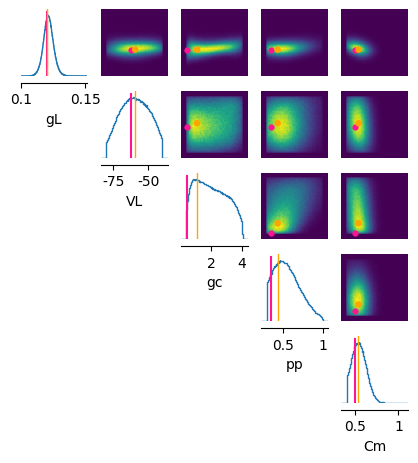

In [33]:
# GRAPHING POSTERIOR
print("MAP estimate:", map_estimate)

fig, axes = analysis.pairplot(
    samples,
    figsize=(5, 5),
    points=np.array([article_params]),
    labels=labels_params,
);

for ax_row in axes:
    for ax in ax_row:

        for coll in ax.collections:
            if hasattr(coll, "set_sizes"):
                coll.set_sizes(np.array([15]))
            coll.set_color("deeppink")
        for ln in ax.lines:
            ln.set_color("deeppink")
            ln.set_markersize(7)
            ln.set_markerfacecolor("deeppink")
            ln.set_markeredgecolor("deeppink")

num_params = map_estimate.shape[0]

for i in range(num_params):
    axes[i, i].axvline(map_estimate[i].item(), color="orange", linewidth=1)

for row in range(num_params):
    for col in range(num_params):
        ax = axes[row, col]

        if len(ax.images) > 0:
            ax.scatter(
            map_estimate[col].item(),
            map_estimate[row].item(),
            color="orange",
            s=22,
            marker="o",
            edgecolor="None",
            linewidth=0.5,
            zorder=10,
        )

# for i in range(num_params):
#     axes[i, i].axvline(low_probability[i], color="cyan", linewidth=1)
#
# for row in range(num_params):
#     for col in range(num_params):
#         ax = axes[row, col]
#
#         if len(ax.images) > 0:
#             ax.scatter(
#             low_probability[col],
#             low_probability[row],
#             color="cyan",
#             s=22,
#             marker="o",
#             edgecolor="None",
#             linewidth=0.5,
#             zorder=10,
#         )
#
# for i in range(num_params):
#     axes[i, i].axvline(high_probability[i], color="gold", linewidth=1)
#
# for row in range(num_params):
#     for col in range(num_params):
#         ax = axes[row, col]
#
#         if len(ax.images) > 0:
#             ax.scatter(
#             high_probability[col],
#             high_probability[row],
#             color="gold",
#             s=22,
#             marker="o",
#             edgecolor="None",
#             linewidth=0.5,
#             zorder=10,
#         )

plt.show()

In [34]:
# SAVE POSTERIOR IMAGE
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_prefix = f"{num_simulations}simulation_{posterior_sample_size}posteriorsample_{timestamp}"

png_filename = os.path.join(save_dir, f"{file_prefix}.png")
pdf_filename = os.path.join(save_dir, f"{file_prefix}.pdf")
svg_filename = os.path.join(save_dir, f"{file_prefix}.svg")

fig.savefig(png_filename, dpi=300, bbox_inches='tight')

fig.savefig(pdf_filename, format="pdf")
fig.savefig(svg_filename, format="svg")

print("figures saved")


Figures saved


In [25]:
# PRIOR vs POSTERIOR SAMPLES
posterior_samples = posterior.sample((9,), x=x_obs)

print("\n9 samples from the posterior:\n")
for s in posterior_samples:
    print(s.tolist())
    print()

prior_samples_9 = prior.sample((9,))

save_path = os.path.join(save_dir, "posterior_prior_samples.txt")

with open(save_path, "w") as f:

    f.write("POSTERIOR SAMPLES\n")

    for s in posterior_samples:
        f.write(f"{s.tolist()}\n\n")

    f.write("\nPRIOR SAMPLES\n")

    for s in prior_samples_9:
        f.write(f"{s.tolist()}\n\n")

print(f"\nsamples saved to:\n{save_path}")



  0%|          | 0/9 [00:00<?, ?it/s]


9 samples from the posterior:

[0.11756128072738647, -57.78364944458008, 3.861736297607422, 0.46173450350761414, 0.6813458204269409]

[0.11873055249452591, -65.74404907226562, 1.4560555219650269, 0.6362886428833008, 0.6633392572402954]

[0.12292215973138809, -41.63836669921875, 3.6729822158813477, 0.6453009247779846, 0.5641301870346069]

[0.12126468867063522, -62.225154876708984, 2.1648285388946533, 0.45397087931632996, 0.4671163856983185]

[0.13110090792179108, -56.65293502807617, 1.697482705116272, 0.5479835867881775, 0.5133538842201233]

[0.12289536744356155, -65.52694702148438, 0.9900556802749634, 0.4869972765445709, 0.5335096716880798]

[0.11386945098638535, -67.95146179199219, 0.547575056552887, 0.346660315990448, 0.5846865177154541]

[0.119028739631176, -47.258731842041016, 3.212221145629883, 0.3913689851760864, 0.46979373693466187]

[0.12175500392913818, -75.98419189453125, 3.2175309658050537, 0.6691145300865173, 0.4050140678882599]


Samples saved to:
CA3PC_Implementaion/idon

In [22]:
#SBC
test_output = CA3model_passive_solver(prior.sample((1,))[0].numpy())

if isinstance(test_output, np.ndarray):
    sim_wrapper = process_simulator(
        CA3model_passive_solver, prior, is_numpy_simulator=True
    )
else:
    sim_wrapper = process_simulator(
        CA3model_passive_solver, prior, is_numpy_simulator=False
    )

num_sbc_samples = 200
num_posterior_samples = 200

prior_samples = prior.sample((num_sbc_samples,))   # (N, num_params)

prior_predictives = []

print("\nrunning simulations for SBC ;)")
for i, theta in enumerate(tqdm(prior_samples, total=num_sbc_samples)):
    sim_out = sim_wrapper(theta.unsqueeze(0))

    if isinstance(sim_out, np.ndarray):
        sim_out = torch.tensor(sim_out)

    prior_predictives.append(sim_out.squeeze())

prior_predictives = torch.stack(prior_predictives)
print("finished")

def identity_summary(x):
    return x

prior_predictive_summary_stats = torch.stack(
    [identity_summary(sim) for sim in prior_predictives]
)
print("\n running SBC")

ranks, dap_samples = run_sbc(
    thetas=prior_samples,
    xs=prior_predictive_summary_stats,
    posterior=posterior,
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=True,
    num_workers=4,
)

print("SBC complete")
print("\nplotting SBC rank distribution")

✔ Simulator returns torch.Tensor → using is_numpy_simulator=False

Running simulations for SBC...


  0%|          | 1/200 [00:05<18:02,  5.44s/it]


KeyboardInterrupt: 

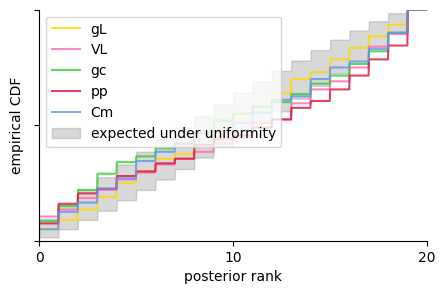

✔ SBC plot generated.


In [35]:
# PLOTTING SBC
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    parameter_labels=labels_params,
    figsize=(5, 3),
)

colors = ["gold", "hotpink", "limegreen", "crimson", "cornflowerblue"]

for line, color in zip(ax.lines, colors):
    line.set_color(color)

ax.legend()

plt.show()
print("✔ SBC plot generated.")

In [38]:
#SAVE SBC
os.makedirs(save_dir, exist_ok=True)

base_path = os.path.join(save_dir, "simulation_based_calibration")

fig.savefig(
    base_path + ".png",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.02,
    facecolor="white"
)

fig.savefig(
    base_path + ".svg",
    format="svg",
    bbox_inches="tight"
)

print("saved")

✔ SBC figure saved as high-quality PNG and SVG
